# Assignment 11 (Bonus Task)

Please add the name, first name, immatriculation number and study program below. Each member of the group has to be added:

- Name: , First Name: , matr. number: , study program:.
- Name:, First Name:, matr. number:, study program:.
- Name:, First Name:, matr. number:, study program:.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# CIFAR-10 class names
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Using device: cpu


## Data Loading and Exploration

Let's load the CIFAR-10 dataset and explore it. PyTorch makes this incredibly easy with built-in datasets!


In [2]:
# Define basic transforms for now (we'll improve these later!)
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=basic_transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=basic_transform)

# Create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(classes)}")
print(f"Image shape: {trainset[0][0].shape}")  # (channels, height, width)


Training samples: 50000
Test samples: 10000
Number of classes: 10
Image shape: torch.Size([3, 32, 32])


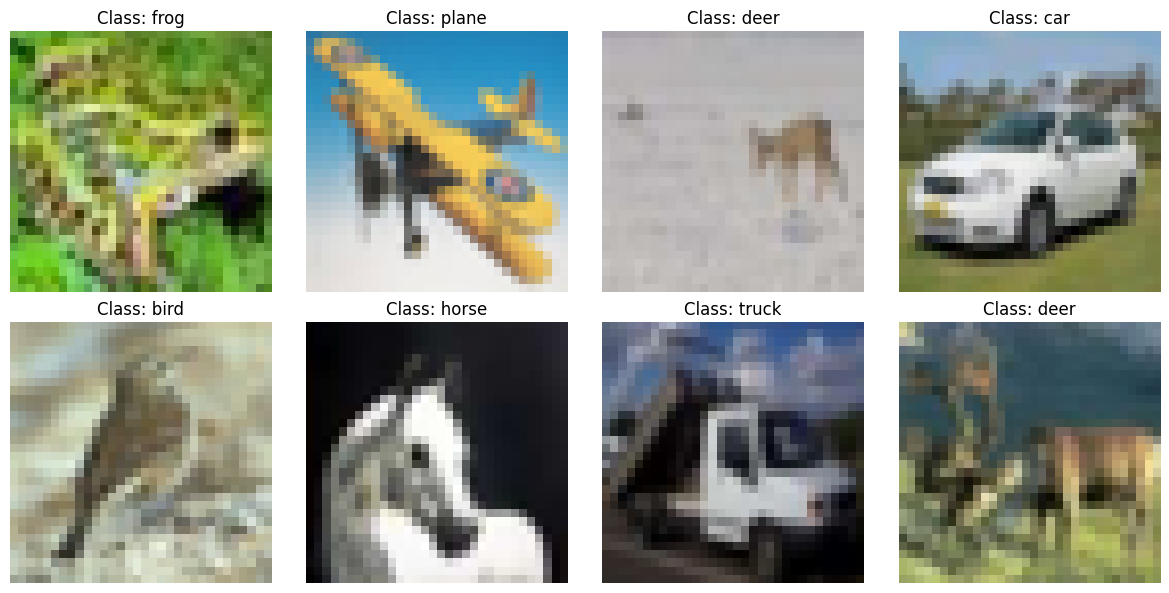

In [3]:
# Let's visualize some sample images
def show_sample_images(loader, num_images=8):
    dataiter = iter(loader)
    images, labels = next(dataiter)
    
    # Denormalize for display
    images = images * 0.5 + 0.5  # Convert back from [-1,1] to [0,1]
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.ravel()
    
    for i in range(num_images):
        img = images[i].permute(1, 2, 0)  # Convert from CHW to HWC
        axes[i].imshow(img)
        axes[i].set_title(f'Class: {classes[labels[i]]}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

show_sample_images(trainloader)

## Baseline Model: Simple CNN

Here's a baseline CNN model. Your job is to beat this! 

**Study this code carefully** - it demonstrates key PyTorch concepts you'll need to master.


In [4]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
model = BaselineCNN().to(device)
print(f"Model: {sum(p.numel() for p in model.parameters()):,} parameters")

Model: 62,006 parameters


## Training and Evaluation Functions

These utility functions will help you train and evaluate your models efficiently.


In [ ]:
def train_model(model, trainloader, testloader, num_epochs=10, learning_rate=0.001):
    """
    Train a PyTorch model and return training history.
    
    Args:
        model: PyTorch model to train
        trainloader: Training data loader
        testloader: Test data loader  
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
    
    Returns:
        Dictionary containing training history
    """
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    
    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_loss': [],
        'test_acc': []
    }
    
    print(f"Starting training for {num_epochs} epochs...")
    start_time = time.time()
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        train_pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device), target.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })
        
        # # Calculate epoch metrics
        # epoch_train_loss = running_loss / len(trainloader)
        # epoch_train_acc = 100. * correct_train / total_train
        
        # Evaluation phase
        epoch_test_loss, epoch_test_acc = evaluate_model(model, testloader, criterion)
        epoch_train_loss, epoch_train_acc = evaluate_model(model, trainloader, criterion)
        
        # Update learning rate scheduler
        scheduler.step(epoch_test_loss)
        
        # Save metrics
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        history['test_loss'].append(epoch_test_loss)
        history['test_acc'].append(epoch_test_acc)
        
        # Print epoch summary
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'  Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f}')
        print('-' * 50)
    
    training_time = time.time() - start_time
    print(f'Training completed in {training_time//60:.0f}m {training_time%60:.0f}s')
    
    return history

def evaluate_model(model, dataloader, criterion=None):
    """
    Evaluate model on given dataset.
    
    Args:
        model: PyTorch model to evaluate
        dataloader: Data loader for evaluation
        criterion: Loss function (optional)
    
    Returns:
        Tuple of (loss, accuracy) if criterion provided, else just accuracy
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            if criterion:
                loss = criterion(output, target)
                running_loss += loss.item()
            
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100. * correct / total
    
    if criterion:
        avg_loss = running_loss / len(dataloader)
        return avg_loss, accuracy
    else:
        return accuracy

def plot_training_history_single(history, title_suffix=""):
    """Plot training history for a single model (original function for backward compatibility)."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss', marker='o')
    ax1.plot(history['test_loss'], label='Test Loss', marker='s')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'Training and Test Loss{title_suffix}')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', marker='o')
    ax2.plot(history['test_acc'], label='Test Accuracy', marker='s')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'Training and Test Accuracy{title_suffix}')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


## Train the Baseline Model

Let's train the baseline model to establish our benchmark. This will take 30 minutes to 1 hour.

Use [Google Colab](https://colab.research.google.com/drive/1yxHOSVrUREla3mUOhaBgsf23NEGw713z?usp=sharing) or [Uni BW Cluster](https://www.hlrs.de/apply-for-computing-time/bw-uni-cluster) if you dont have enough local compute resources!


TRAINING BASELINE MODEL
Starting training for 10 epochs...


Epoch 1/10 [Train]: 100%|██████████| 391/391 [00:27<00:00, 14.08it/s, Loss=0.9751, Acc=65.53%]


Epoch 1/10:
  Train Loss: 0.9000, Train Acc: 67.90%
  Test Loss: 1.0618, Test Acc: 62.58%
  LR: 0.001000
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s, Loss=0.9459, Acc=66.28%]


Epoch 2/10:
  Train Loss: 0.8947, Train Acc: 68.29%
  Test Loss: 1.0760, Test Acc: 62.36%
  LR: 0.001000
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 391/391 [00:26<00:00, 14.53it/s, Loss=0.9228, Acc=67.38%]


Epoch 3/10:
  Train Loss: 0.8864, Train Acc: 68.61%
  Test Loss: 1.0903, Test Acc: 62.25%
  LR: 0.001000
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 391/391 [00:27<00:00, 14.36it/s, Loss=0.9013, Acc=67.68%]


Epoch 4/10:
  Train Loss: 0.8595, Train Acc: 69.52%
  Test Loss: 1.0746, Test Acc: 62.83%
  LR: 0.001000
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 391/391 [00:27<00:00, 14.37it/s, Loss=0.8756, Acc=68.73%]


Epoch 5/10:
  Train Loss: 0.8338, Train Acc: 70.33%
  Test Loss: 1.0701, Test Acc: 62.71%
  LR: 0.000500
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 391/391 [00:28<00:00, 13.92it/s, Loss=0.8122, Acc=71.23%]


Epoch 6/10:
  Train Loss: 0.7847, Train Acc: 72.29%
  Test Loss: 1.0517, Test Acc: 63.20%
  LR: 0.000500
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 391/391 [00:28<00:00, 13.88it/s, Loss=0.7929, Acc=71.98%]


Epoch 7/10:
  Train Loss: 0.7704, Train Acc: 72.84%
  Test Loss: 1.0671, Test Acc: 63.39%
  LR: 0.000500
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 391/391 [00:27<00:00, 14.20it/s, Loss=0.7798, Acc=72.45%]


Epoch 8/10:
  Train Loss: 0.7445, Train Acc: 73.92%
  Test Loss: 1.0538, Test Acc: 63.74%
  LR: 0.000500
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 391/391 [00:27<00:00, 14.04it/s, Loss=0.7692, Acc=72.85%]


Epoch 9/10:
  Train Loss: 0.7296, Train Acc: 74.40%
  Test Loss: 1.0571, Test Acc: 63.94%
  LR: 0.000500
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 391/391 [00:27<00:00, 13.97it/s, Loss=0.7535, Acc=73.31%]


Epoch 10/10:
  Train Loss: 0.7156, Train Acc: 74.97%
  Test Loss: 1.0561, Test Acc: 64.00%
  LR: 0.000250
--------------------------------------------------
Training completed in 10m 4s


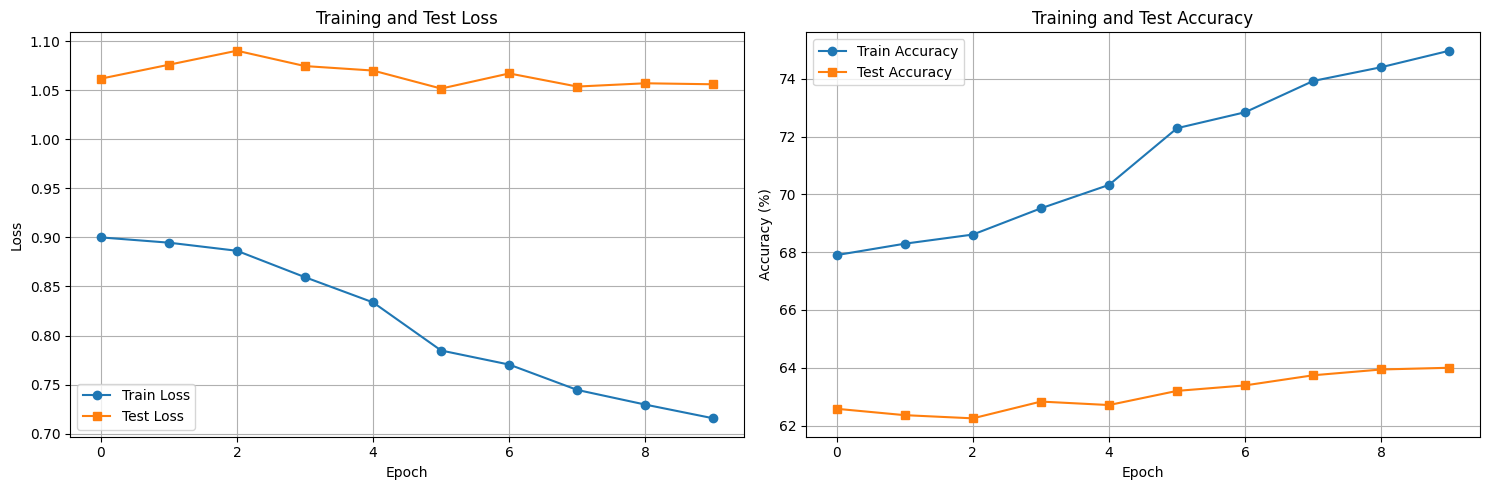


Final test accuracy: 64.00%


In [9]:
# Train the baseline model
print("TRAINING BASELINE MODEL")
print("=" * 50)

history = train_model(
    model=model,
    trainloader=trainloader, 
    testloader=testloader,
    num_epochs=10,
    learning_rate=0.001
)

# Plot comparison
plot_training_history_single(history)

# Final test accuracy
final_test_acc = history['test_acc'][-1]
print(f"\nFinal test accuracy: {final_test_acc:.2f}%")


---

## Beat the Baseline!

Now comes the exciting part - it's your turn to design a better model and beat the baseline!
### Assignment Requirements

#### **Mandatory Requirements:**
1. **Use PyTorch**: All models must be implemented using PyTorch
2. **Beat Baseline**: Beat the baseline model on test accuracy
3. **Document Your Approach**: Explain your design choices and experiments

#### **What You Can Modify:**
- ✅ **Model Architecture**: Add dropout, Design new CNN architectures, add residual connections, try different layer types
- ✅ **Data Augmentation**: Add rotation, flipping, cropping, color jittering, etc.
- ✅ **Training Strategy**: Different optimizers, learning rates, schedules, regularization
- ✅ **Advanced Techniques**: Mixup, CutMix, label smoothing, etc.

#### **What You Cannot Do:**
- ❌ **External Data**: Cannot use additional training data beyond CIFAR-10
- ❌ **Manual Labeling**: Cannot manually correct labels
- ❌ **Test Set Peeking**: Cannot use test set for validation or hyperparameter tuning


---

## Your Implementation Section

**This is where you implement your solution!** 

Create as many cells as you need below. We recommend organizing your work as follows:

### Suggested Structure:
1. **Data Augmentation**: Implement improved transforms
2. **Model Architecture**: Design your new model
3. **Training Setup**: Configure optimizer, scheduler, etc.
4. **Training Loop**: Train your model
5. **Evaluation**: Test your model and compare with baseline
6. **Analysis**: Discuss what worked and what didn't
